# Modeling Data With NumPy: Image Volumes
In many types medical imaging studies, such as CT and MRI, there is a sequence of stacked images that are acquired. _The images are usually acquired from the feet and stacked toward the head._ Each image corresponds to a slice through the body.

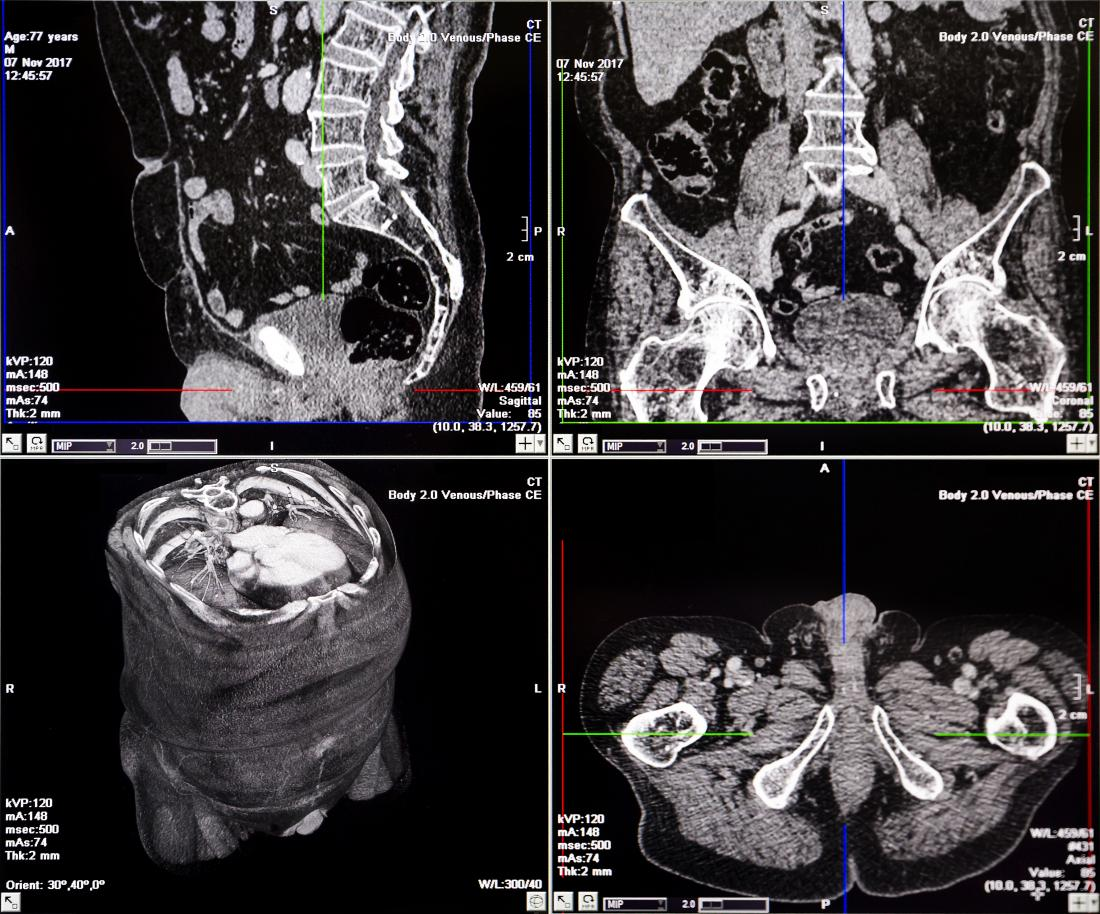

* CT scans use X-rays to acquire their images. Denser tissue stops more of the X-ray though less dense tissue. The intensity of the image pixel corresponds to the type of tissue through which the x-ray passed.
  - Less dense tissue: lung (which is mostly air), fat, water appears dark.
  - More dense tissue: muscle and bone, appears light.
* CT scans only have a single channel of data, which makes them similar to grayscale images.
* Because the images are acquired as a series, they will often be stacked into a "volume" for visualization for analysis.

#### Anatomy for Medical Imaging
* Medical images are described in terms of an "anatomical plane".
  - Sagittal or median plane (longitudinal, anteroposterior) divides the body into left and right
  - Coronal or frontal plane (vertical) divides the body into dorsal and ventral (back and front, or posterior and anterior)
  - Transverse or axial plane (lateral, horizontal) divides the body into cranial and caudal (head and tail)
  
##### Example 1: Transverse Plane
Brain as viewed from below. This is an example of the transverse plane.

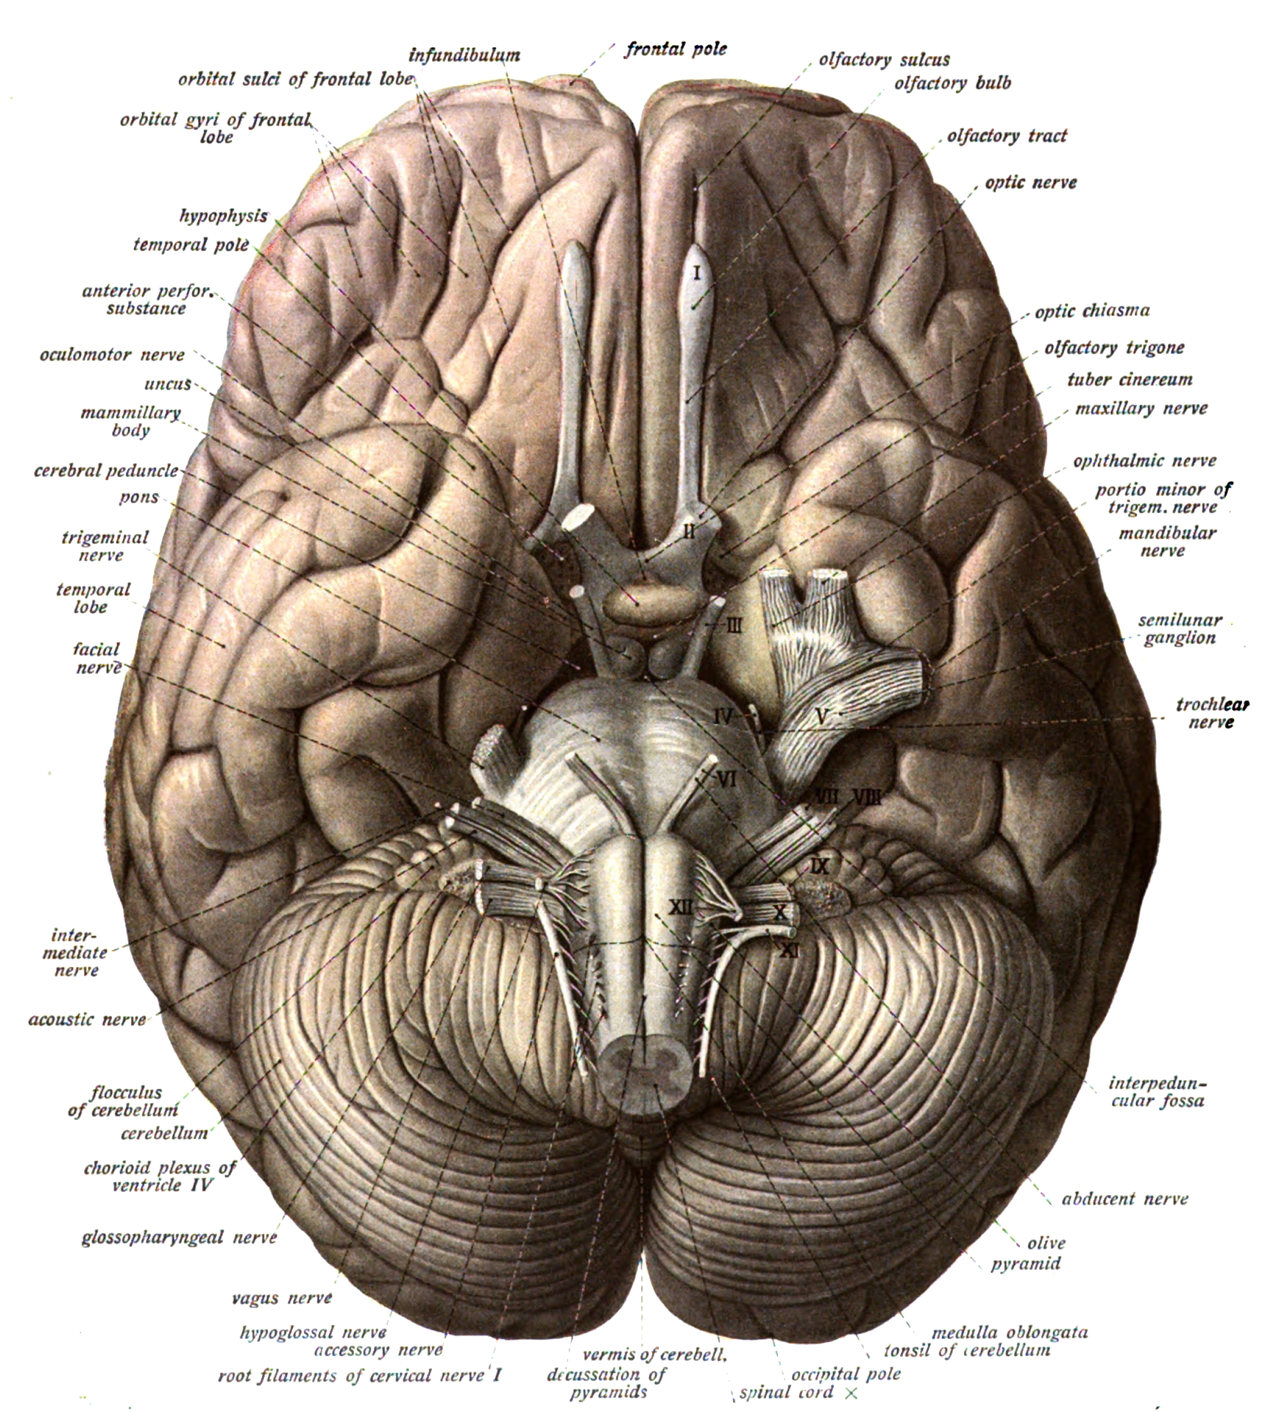

##### Example 2: Sagittal Plane
Brain cut in half through the midsection. This is an example of the sagittal plane.

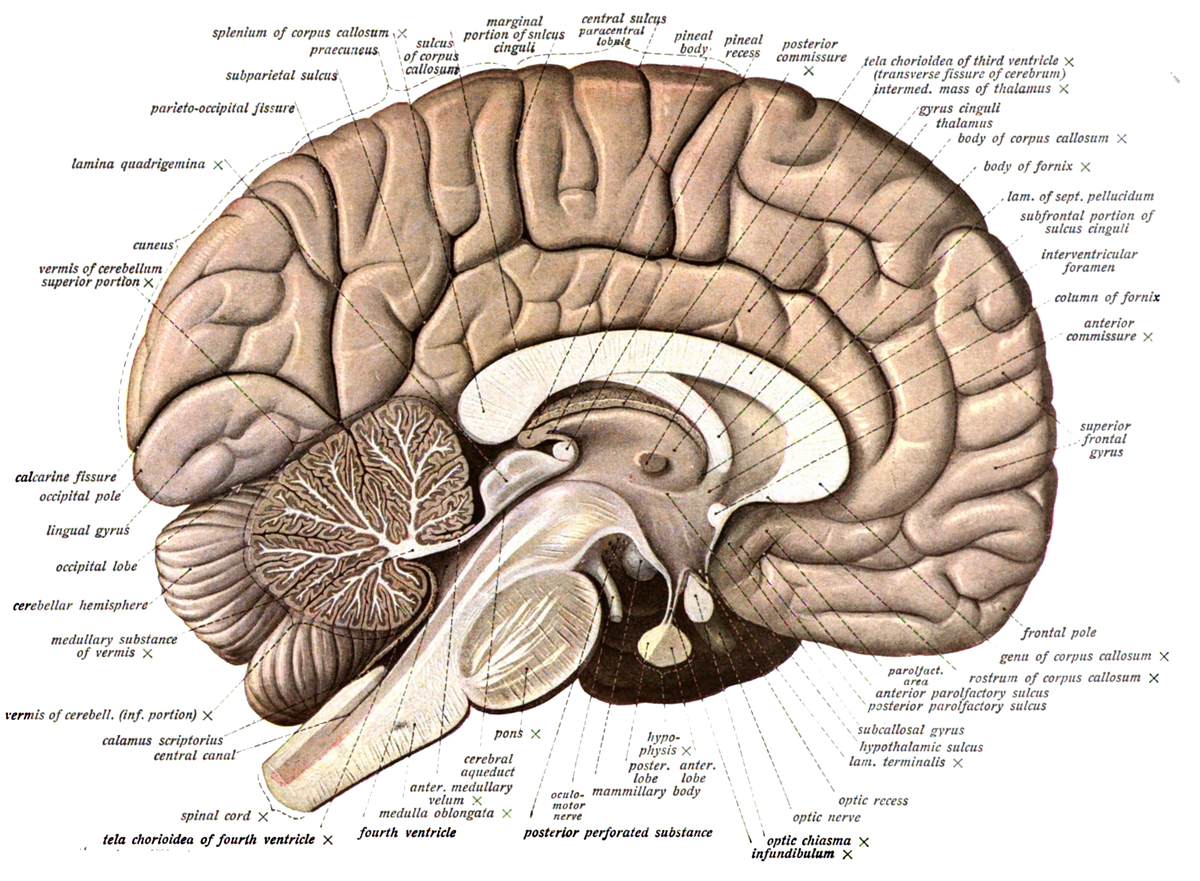

### Import Dependencies and Configure Notebook

In [ ]:
# NumPy and plotting tools
import numpy as np
import matplotlib as plt
import seaborn as sns

# Utilities for working with remote data
import requests
from io import BytesIO
import zipfile

# Image processing shortcuts
import imageio

# SciKit-Image tools for working with the image data
from skimage import exposure
import skimage.morphology as morp
from skimage.filters import rank

### Retrieve Data Archive and Unpack to NumPy Array

In [ ]:
# Retrieve zip archive from website, create stream
ctr = requests.get(
    'https://oak-tree.tech/documents/156/example.lung-ct.volume-3d.zip')
ctzip = BytesIO(ctr.content)

# Create a  data in preparation of processing
ct_fdata = zipfile.ZipFile(ctzip)

# Load archived folder of DICOM image data
# The comprehension iterates through images and loads them to a stacked
# NumPy array. The
ct_idata = np.array(
    [imageio.imread(ct_fdata.open(fname)) for fname in ct_fdata.namelist()])

In [ ]:
# Check the shape of the imported data
ct_idata.shape

### Visualize CT Scan

#### Single Image

In [ ]:
# Show one sample image from the archive
plt.pyplot.figure(figsize=(8, 8), dpi=100)
plt.pyplot.imshow(ct_idata[15,:,:], cmap=plt.cm.gray)

#### Image Series

In [ ]:
# Helper method to generate panel series of CT imagd data

def display_series(idata, sstep=5, fcols=3, cmap=plt.cm.gray):
    ''' Create a sample panel to inspect the provided series as a whole.
        Samples images from the sequence based on the provided step.
        @input sstep (int, default=5): Number of images to skip when creating the
            series panel graphic.
        @input fcols (int, default=3): Number of columns to display in the
            panel graphic.
    '''
    frows = idata.shape[0]//sstep//fcols + 1
    
    for i,idx in enumerate(range(0, idata.shape[0], sstep)):
        sub = plt.pyplot.subplot(frows, fcols, i+1)
        sub.imshow(idata[idx,:,:], cmap=cmap)

In [ ]:
# Create a sample panel to inspect the series as a whole
plt.pyplot.figure(figsize=(15,35))
display_series(ct_idata)

* The series as a whole has "poor contrast." Pixel values are dark and the relative difference between types of tissue is small.
* SciKit-Image includes a number of routines that can be used to optimize the image.
  - The pixel intensity histogram can be helpful in understanding the distribution of values.
  - _When working with a sequence of images, calculations and adjustments should be made on the volume as a whole._

In [ ]:
# Plot histogram intensity for the entire volume. Working on the entire
# volume is desirable because it will allow for a uniform transform.
ct_idata_flat = ct_idata.flatten()
ct_px_min = ct_idata_flat.min()
ct_px_max = ct_idata_flat.max()

plt.pyplot.figure(figsize=(8, 8))
sns.distplot(ct_idata_flat)
plt.pyplot.title('Pixel Intensities', loc='left', fontsize=18)
plt.pyplot.title('Min: %s, Max: %s' % (ct_px_min, ct_px_max),
          loc='right', fontsize=13, color='grey')

* Within CT images, the pixel values will often range from -1024 HU to 3000 HU.
  - -1000 is no (or very minimal) defraction, associated with air
  - +3000 is associated with very high density objects, metal or contrast agent
  - Body tissues are somewhere inbetween
* Histogram shows that there is a huge set of pixels corresponding to air and a second set corresponding to tissue.
* Removing the air and high contrast pixels would allow for the tissue contrast to incrase..
  - The two cutoffs can be applied by creating a boolean mask which looks for pixels above an upper bound and below a lower bound.
  - From visual inspection of the histogram, air values seem to be less than -250 (though this will scaled, see below for details).
  - High contrast pixels appear to be above 1000 in intensity.
  - To ensure that the image appears as expected, all values will be shifted so that air (black) starts at 0.
    + If the values are not shifted, when the boolean mask is applied all values will become 0. At present, "0" is in the middle of the tissue values.

In [ ]:
# Apply contrast stretching to the image
ct_px_cutoff_lower = -250
ct_px_cutoff_upper = 1250

# Create threshold mask by applying lower/upper cutoffs
ct_bpfilter = (ct_idata > ct_px_cutoff_lower) & (ct_idata < ct_px_cutoff_upper)

In [ ]:
# Shift range of all values based on the minimum.
# This sets the "air" reference to 0.
ct_idata1 = exposure.rescale_intensity(
    (ct_idata+abs(ct_px_min)) * ct_bpfilter,
    in_range=(550, ct_px_cutoff_upper+abs(ct_px_min)))

In [ ]:
# Visualize the resulting transformation
plt.pyplot.figure(figsize=(15,35))
display_series(ct_idata1)

In [ ]:
# Visualize the new histogram
plt.pyplot.figure(figsize=(8, 8))
sns.distplot(ct_idata1.flatten())